# EBI Metadata - General Insights

In [1]:
import pandas as pd

df = pd.read_csv('../data/metadata_EBI_preprocessed.csv',
                 dtype={'collected_by': object,
                        'collection_date': object,
                        'culture_collection': object,
                        'identified_by': object,
                        'isolate': object,
                        'isolation_source': object,
                        'keywords': object,
                        'lab_host': object,
                        'location': object,
                        'sample_accession': object,
                        'strain': object,
                        'study_accession': object})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520583 entries, 0 to 2520582
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accession             object 
 1   base_count            int64  
 2   collected_by          object 
 3   collection_date       object 
 4   country_and_region    object 
 5   culture_collection    object 
 6   dataclass             object 
 7   description           object 
 8   environmental_sample  bool   
 9   first_public          object 
 10  germline              bool   
 11  host                  object 
 12  identified_by         object 
 13  isolate               object 
 14  isolation_source      object 
 15  keywords              object 
 16  lab_host              object 
 17  last_updated          object 
 18  location              object 
 19  mol_type              object 
 20  sample_accession      object 
 21  scientific_name       object 
 22  sequence_md5          object 
 23  sequenc

## Descriptive Statistics

In [177]:
import pandas_profiling
import json

# Create fancy profile report
# See https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html for advanced usage
profile_ebi = pandas_profiling.ProfileReport(df,
                                             title='EBI Metadata Profiling',
                                             minimal=True,
                                             correlations={'pearson': {'calculate': True},
                                                           'spearman': {'calculate': True},
                                                           'kendall': {'calculate': True},
                                                           'phi_k': {'calculate': True},
                                                           'cramers': {'calculate': False}})

# Add definitions
with open('json_data/definitions_EBI_metadata.json') as f:
    definitions_ebi_metadata = json.load(f)
profile_ebi.config.variables.descriptions = definitions_ebi_metadata

# Save as html
profile_ebi.to_file(output_file='../data/metadata_EBI_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Investigation of National Bias

In [ ]:
# Separate dataframe into countries appearing often and rarely
threshold = 1000

rare_countries = df[df['country'].map(df['country'].value_counts()) < threshold]
rare_countries['country'].value_counts()

In [ ]:
popular_countries = df[df['country'].map(df['country'].value_counts()) >= threshold]
popular_countries['country'].value_counts()

In [ ]:
with open('json_data/country_inhabitants_map.json') as f:
    country_inhabitants_map = json.load(f)

In [2]:
import os

if not os.path.isdir('../plots/general_country_counts'):
    os.mkdir('../plots/general_country_counts')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Plot distribution of countries appearing more than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(18, 16))
    sns.countplot(data=popular_countries,
                  x='country',
                  hue=hue,
                  order=popular_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with >= 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(popular_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        new_height = patch.get_height() / country_inhabitants_map[country]
        max_y = max(max_y, new_height)
        patch.set_height(new_height)

    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    plt.savefig(f'../plots/general_country_counts/popular_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

In [ ]:
# Plot distribution of countries appearing less than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(36, 18))
    sns.countplot(data=rare_countries,
                  x='country',
                  hue=hue,
                  order=rare_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with < 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(rare_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        if country == 'Unknown':
            new_height = 0.0
        else:
            new_height = patch.get_height() / country_inhabitants_map[country]

        max_y = max(max_y, new_height)
        patch.set_height(new_height)
    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    plt.savefig(f'../plots/general_country_counts/rare_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

## Investigation of Temporal Bias

In [4]:
# A) Plot density
plotdata = df.copy(deep=True)
plotdata['collection_date'] = pd.to_datetime(plotdata['collection_date'])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(24, 12))
sns.kdeplot(data=plotdata,
            x='collection_date',
            hue='keywords')
fig.suptitle('Density of Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/collection_date_density.png', dpi=300)
plt.close()

In [18]:
# B) Plot absolute count
date_counts = plotdata.groupby(['collection_date', 'keywords']).count().sum(axis=1)
date_counts

collection_date  keywords                                 
2020-03-02       purpose_of_sampling:baseline_surveillance       22
2020-03-09       purpose_of_sampling:baseline_surveillance       22
2020-03-10       purpose_of_sampling:baseline_surveillance       22
2020-03-13       purpose_of_sampling:baseline_surveillance       24
2020-03-16       purpose_of_sampling:baseline_surveillance       66
                                                              ...  
2021-11-13       purpose_of_sampling:baseline_surveillance     8160
2021-11-14       purpose_of_sampling:baseline_surveillance     2496
2021-11-15       purpose_of_sampling:baseline_surveillance    16968
2021-11-16       purpose_of_sampling:baseline_surveillance    10512
2021-11-17       purpose_of_sampling:baseline_surveillance       96
Length: 708, dtype: int64

In [21]:
date_counts.index.get_level_values(0)

DatetimeIndex(['2020-03-02', '2020-03-09', '2020-03-10', '2020-03-13',
               '2020-03-16', '2020-03-30', '2020-04-01', '2020-04-03',
               '2020-04-04', '2020-04-05',
               ...
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17'],
              dtype='datetime64[ns]', name='collection_date', length=708, freq=None)

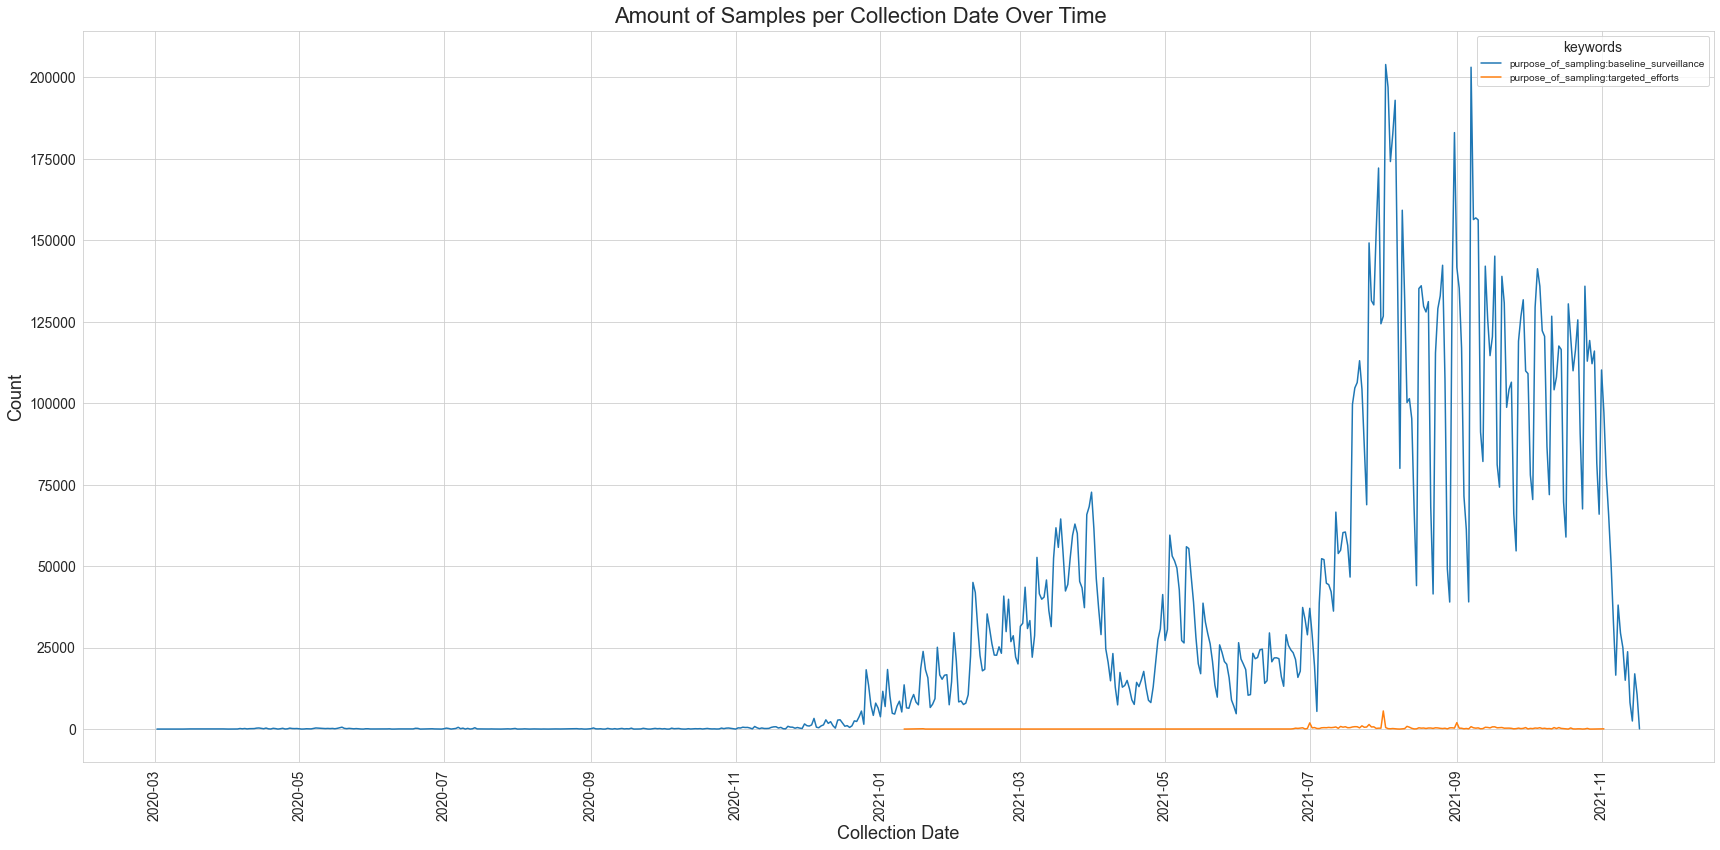

In [25]:
sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.lineplot(x=date_counts.index.get_level_values(0),
             y=date_counts.tolist(),
             hue=date_counts.index.get_level_values(1))
fig.suptitle('Amount of Samples per Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../plots/collection_date_count.png', dpi=300)
plt.close()

# -> temporal bias around March 2021 and August until November 2021 exist!

## Investigation of Existing Ages

In [174]:
original_len = len(df)
original_len  # 2,520,583

2520583

In [38]:
# Count how many samples do contain (valuable) information about age
df_with_ages = df[df['age'].notna()]
len(df_with_ages)  # 9,948

9948

In [34]:
# Show how age is set for patients with age information given in days or months
df_with_ages[df_with_ages['host'].str.contains('day|months|mos|MOS')][['age', 'host']]

,age,host
993150,0.67,Homo sapiens; Male age 8 months
993264,0.33,Homo sapiens; Female age 4 months
993296,0.25,Homo sapiens; Male age 3 months
993677,0.14,Homo sapiens; Male age 50 days
993775,0.08,Homo sapiens; Female age 1 months
993802,0.83,Homo sapiens; Female age 10 months
993970,0.92,Homo sapiens; Female age 11 months
994025,0.58,Homo sapiens; Female age 7 months
994601,0.92,Homo sapiens; Female age 11 months
994679,0.42,Homo sapiens; Female age 5 months


In [140]:
# Check how host is set if age in not numeric and host is not equal to main value "homo sapiens" (for debugging and to finally check all set ages)
df['age'] = df['age'].astype(str)
non_numeric_ages = df[df['age'].apply(lambda x: not x.isnumeric())]
non_numeric_ages[non_numeric_ages['host'].str.lower() != 'homo sapiens'][['age', 'host']]

,age,host
460,nan,"Homo sapiens, female"
461,nan,"Homo sapiens, male"
462,nan,"Homo sapiens, male"
463,nan,"Homo sapiens, female"
464,nan,"Homo sapiens, male"
...,...,...
2242394,nan,NaN
2252312,nan,NaN
2474640,nan,not provided
2496096,nan,not provided


In [40]:
# Convert ages to integers for simpler plotting
df_with_ages['age'] = df_with_ages['age'].astype(int)

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# Sort by age
plotdata = df_with_ages.sort_values(by=['age'])

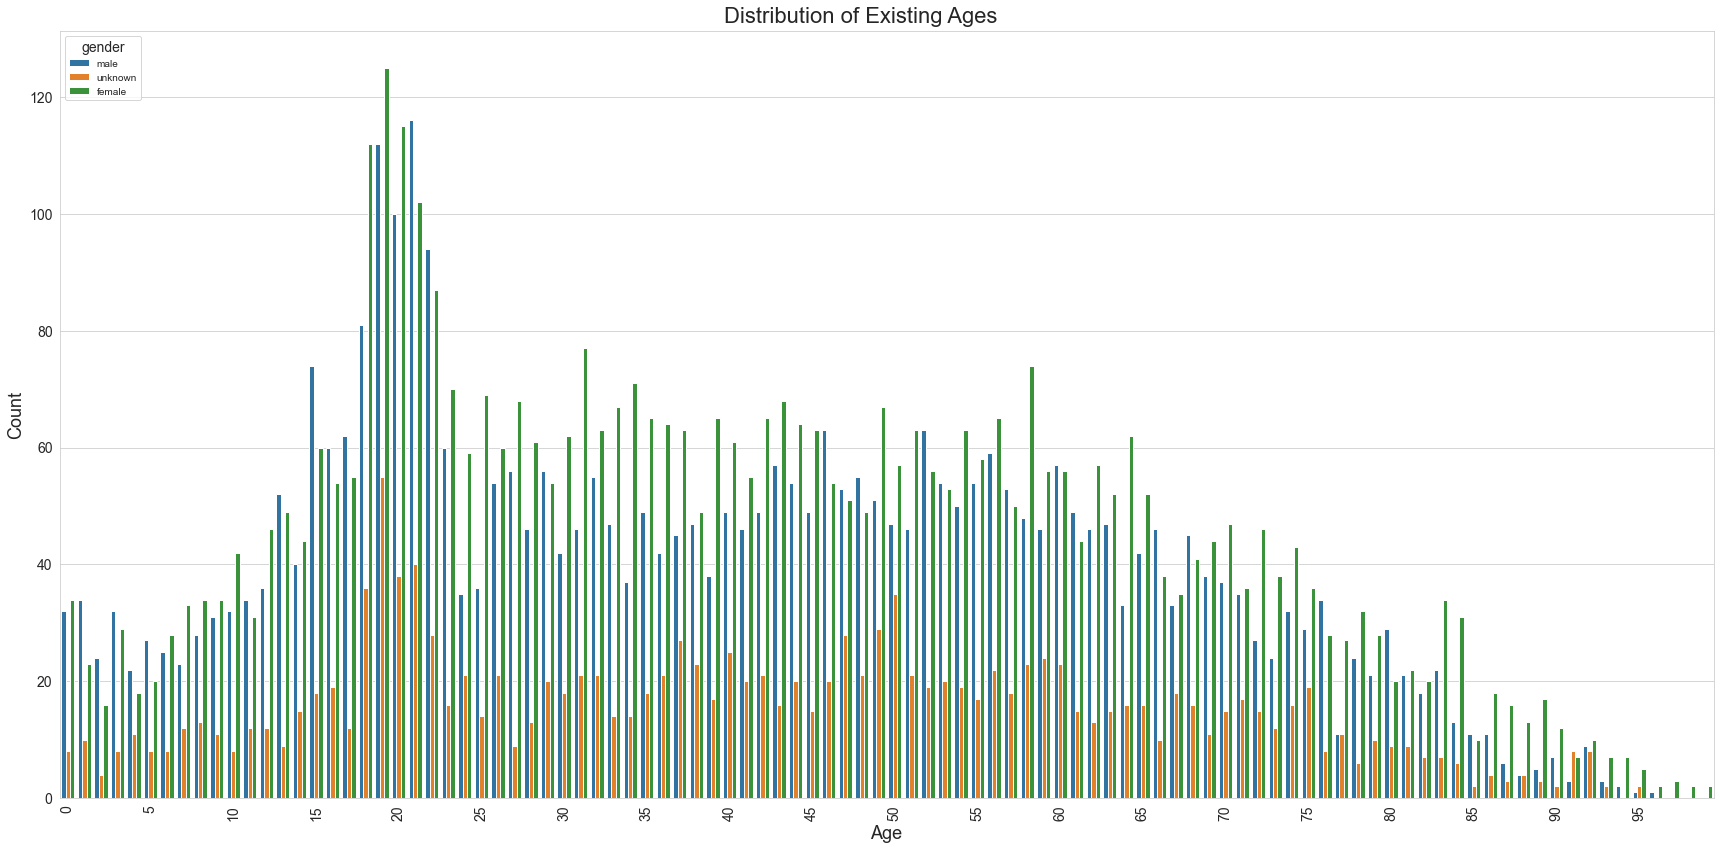

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.countplot(data=plotdata,
              x='age',
              hue='gender')
fig.suptitle('Distribution of Existing Ages', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show only every 5th x-tick (aka every 5th age on x-axis)
for i, label in enumerate(ax.get_xticklabels()):
    if i % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
plt.savefig('../plots/age_distribution.png', dpi=300)
plt.close()

In [50]:
plotdata['country'].value_counts()

USA               9656
Russia             265
Italy               10
Czech Republic       6
Germany              5
China                5
Pakistan             1
Name: country, dtype: int64

In [ ]:
import os

if not os.path.isdir('../plots/age_distribution'):
    os.mkdir('../plots/age_distribution')

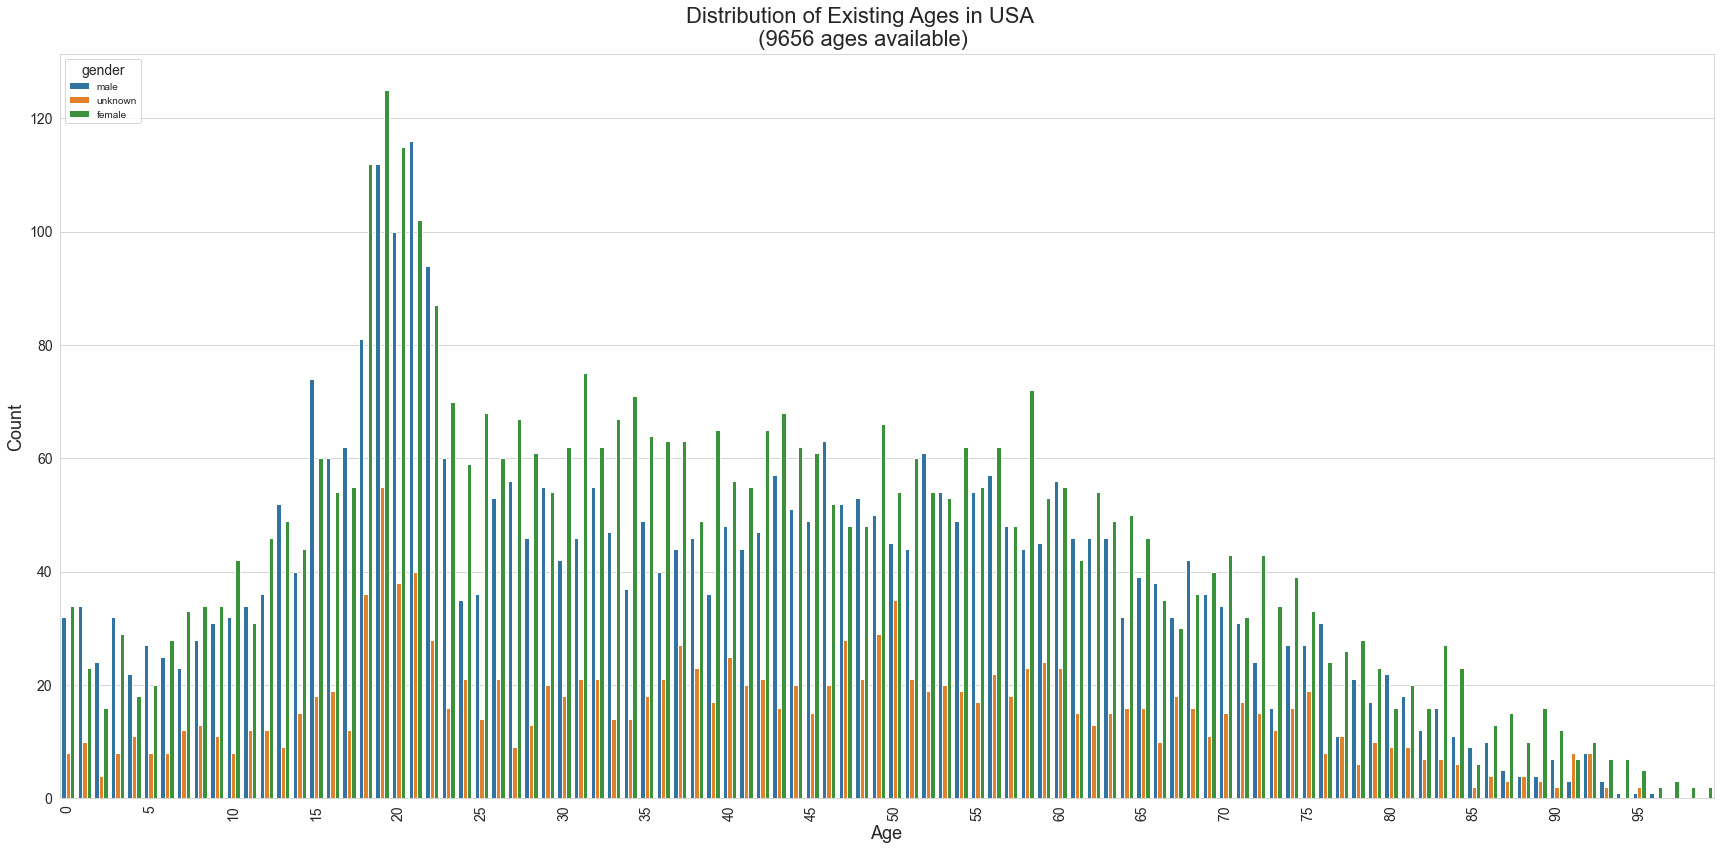

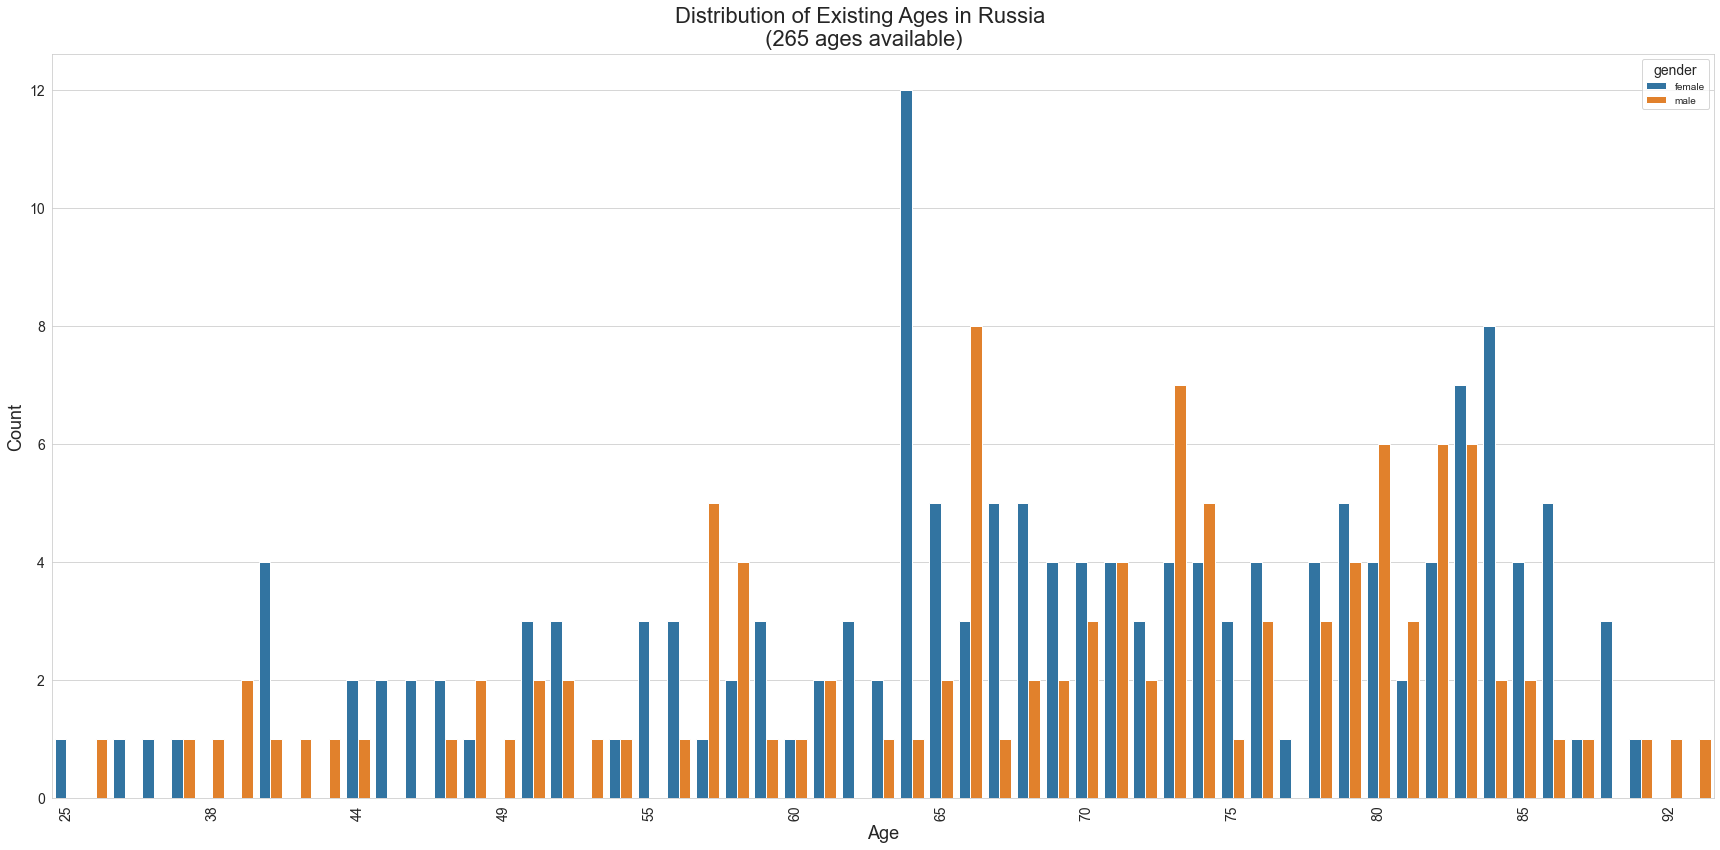

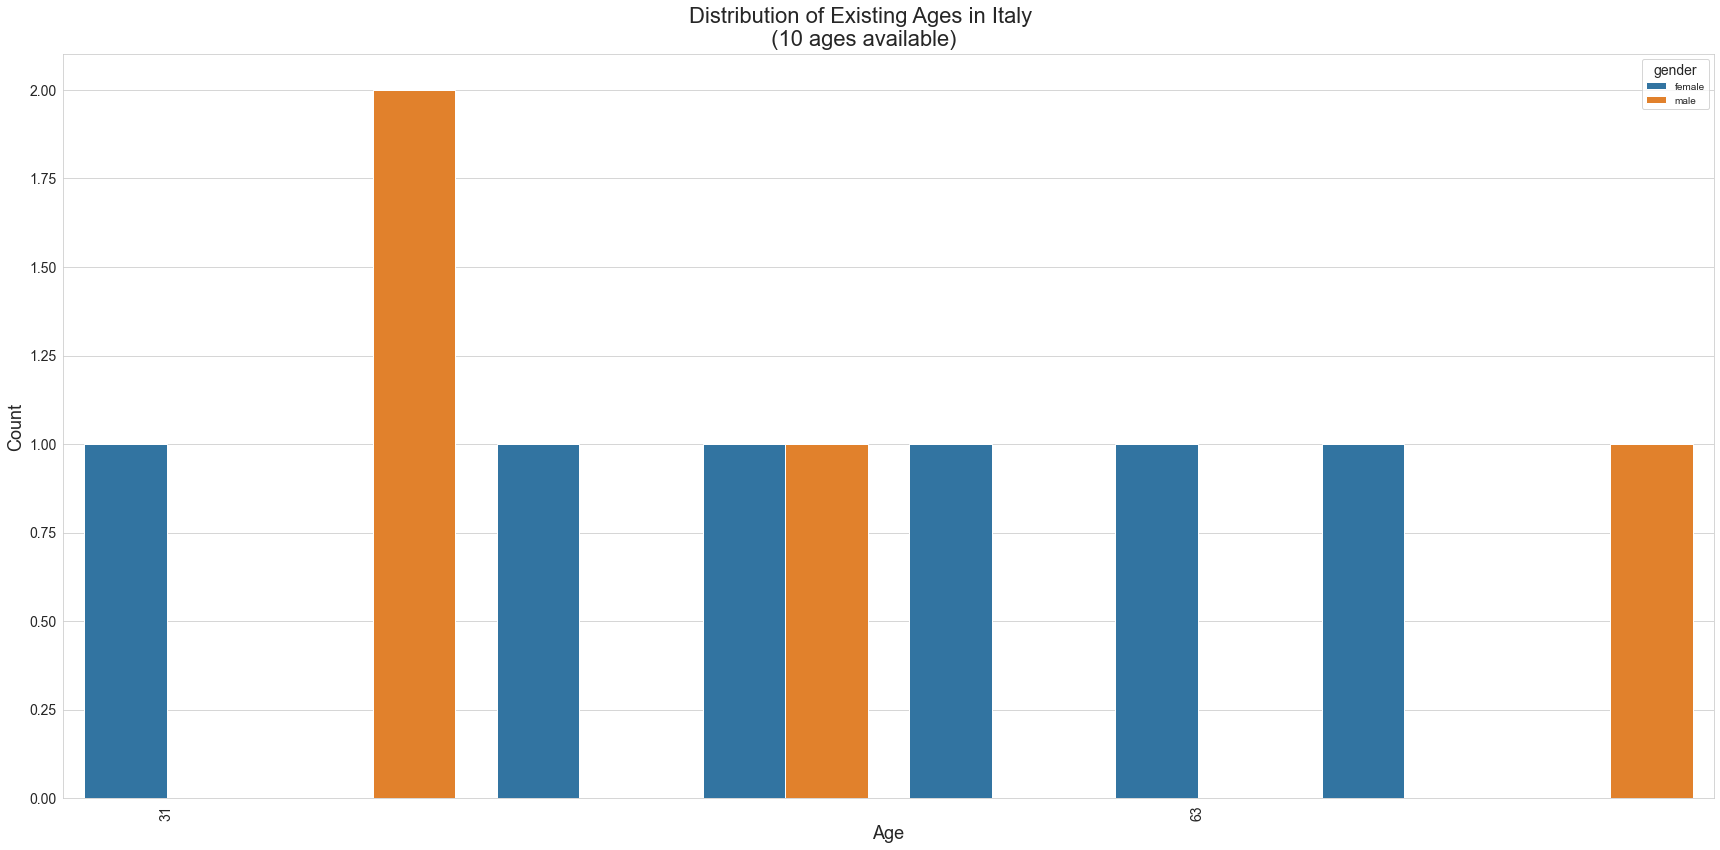

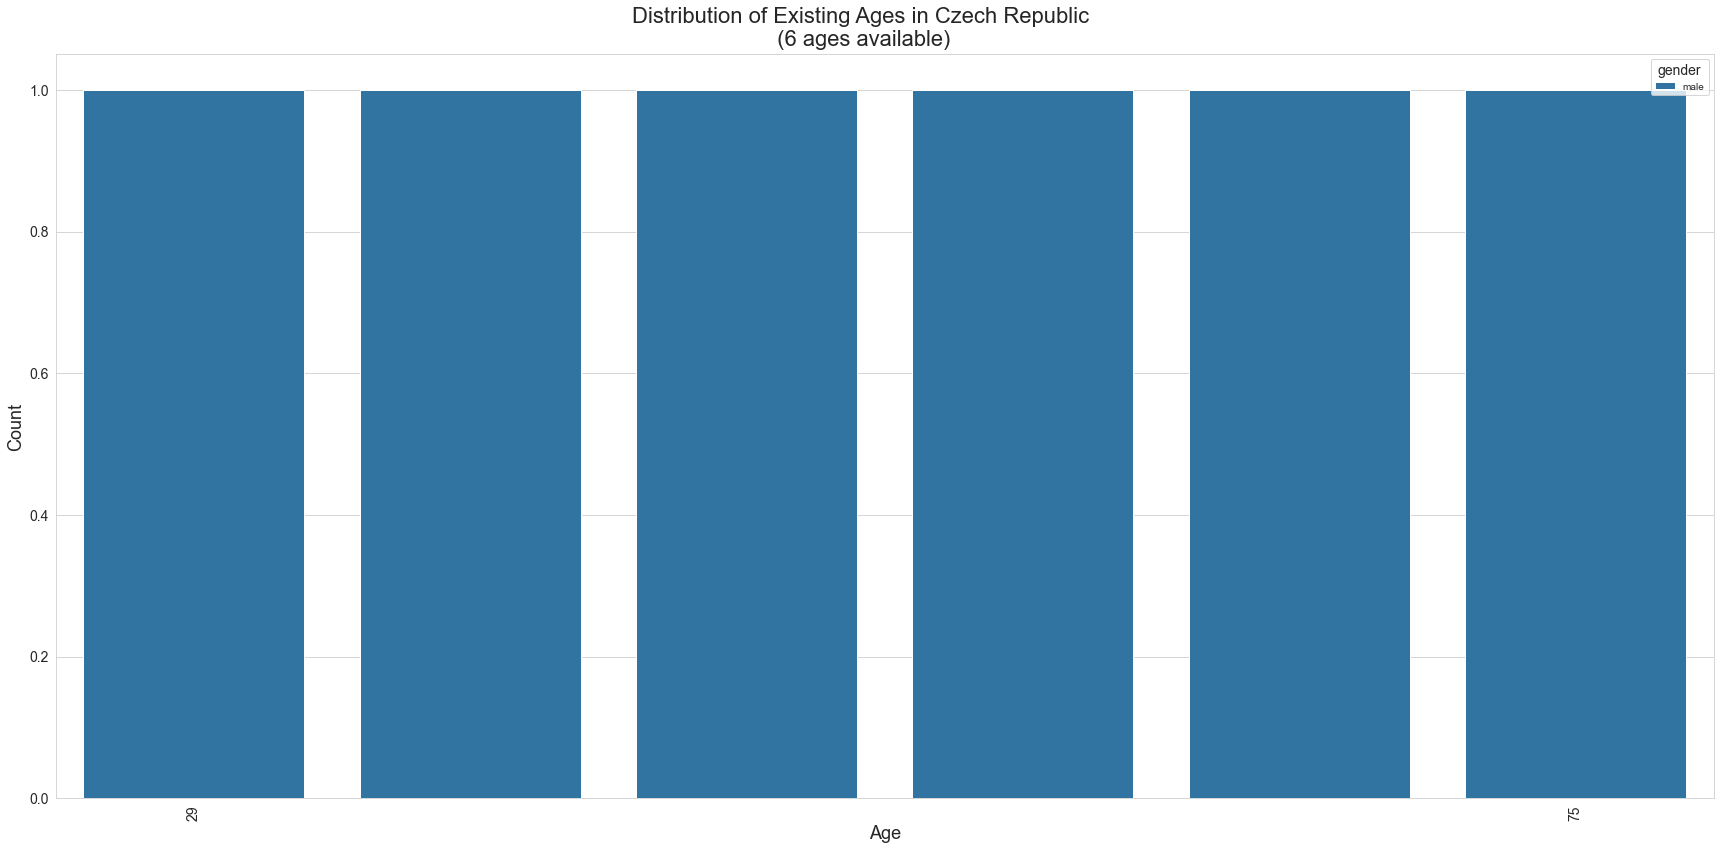

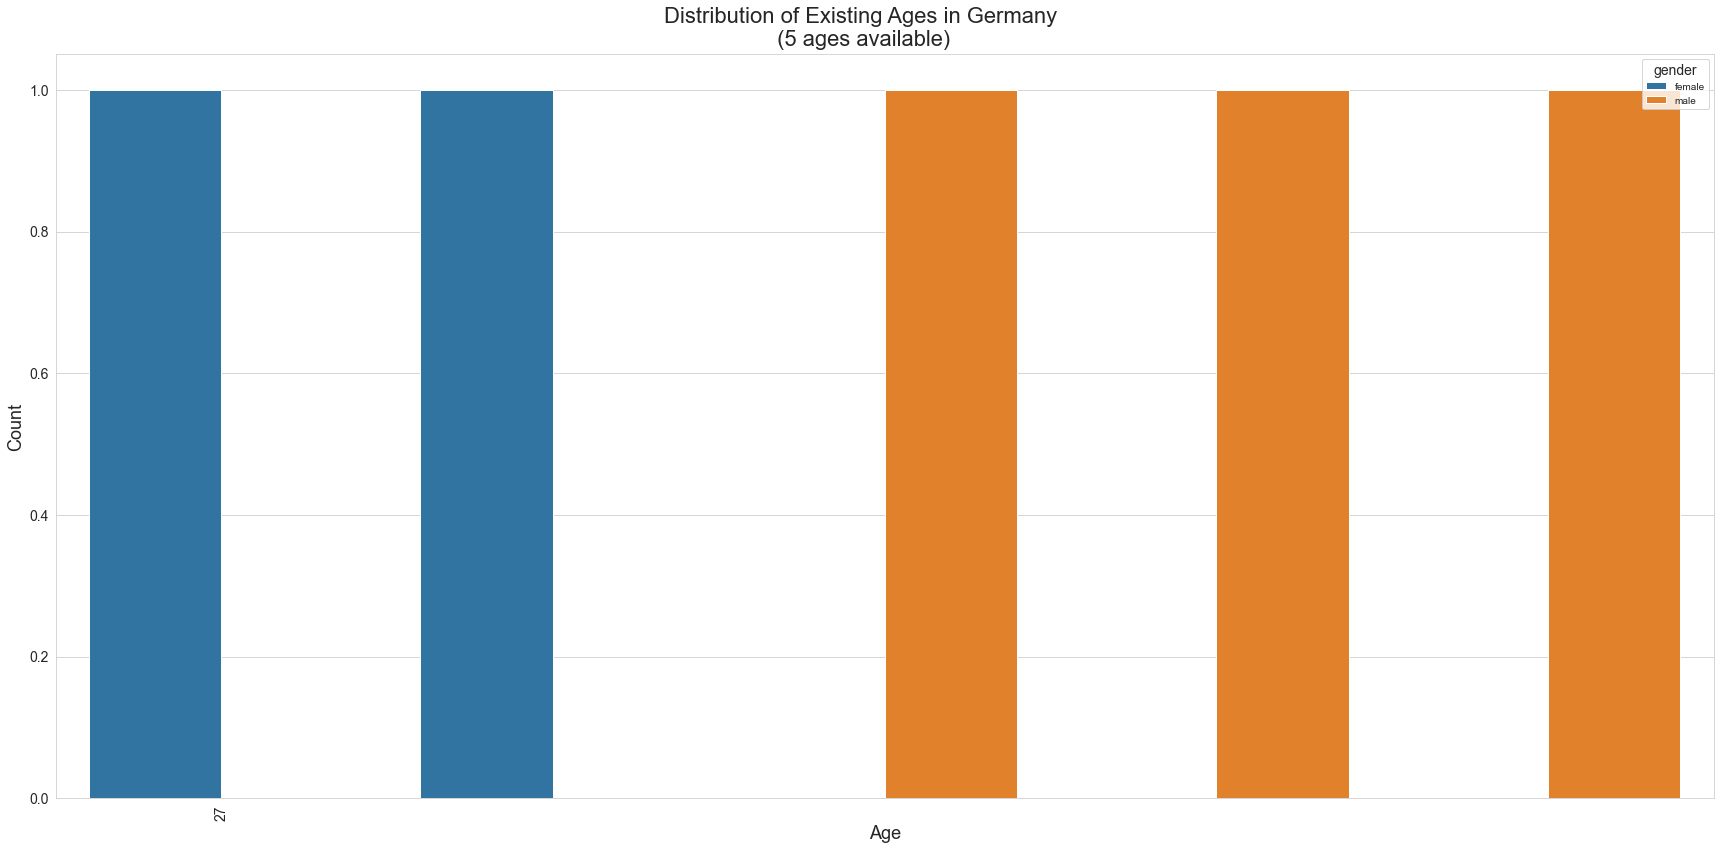

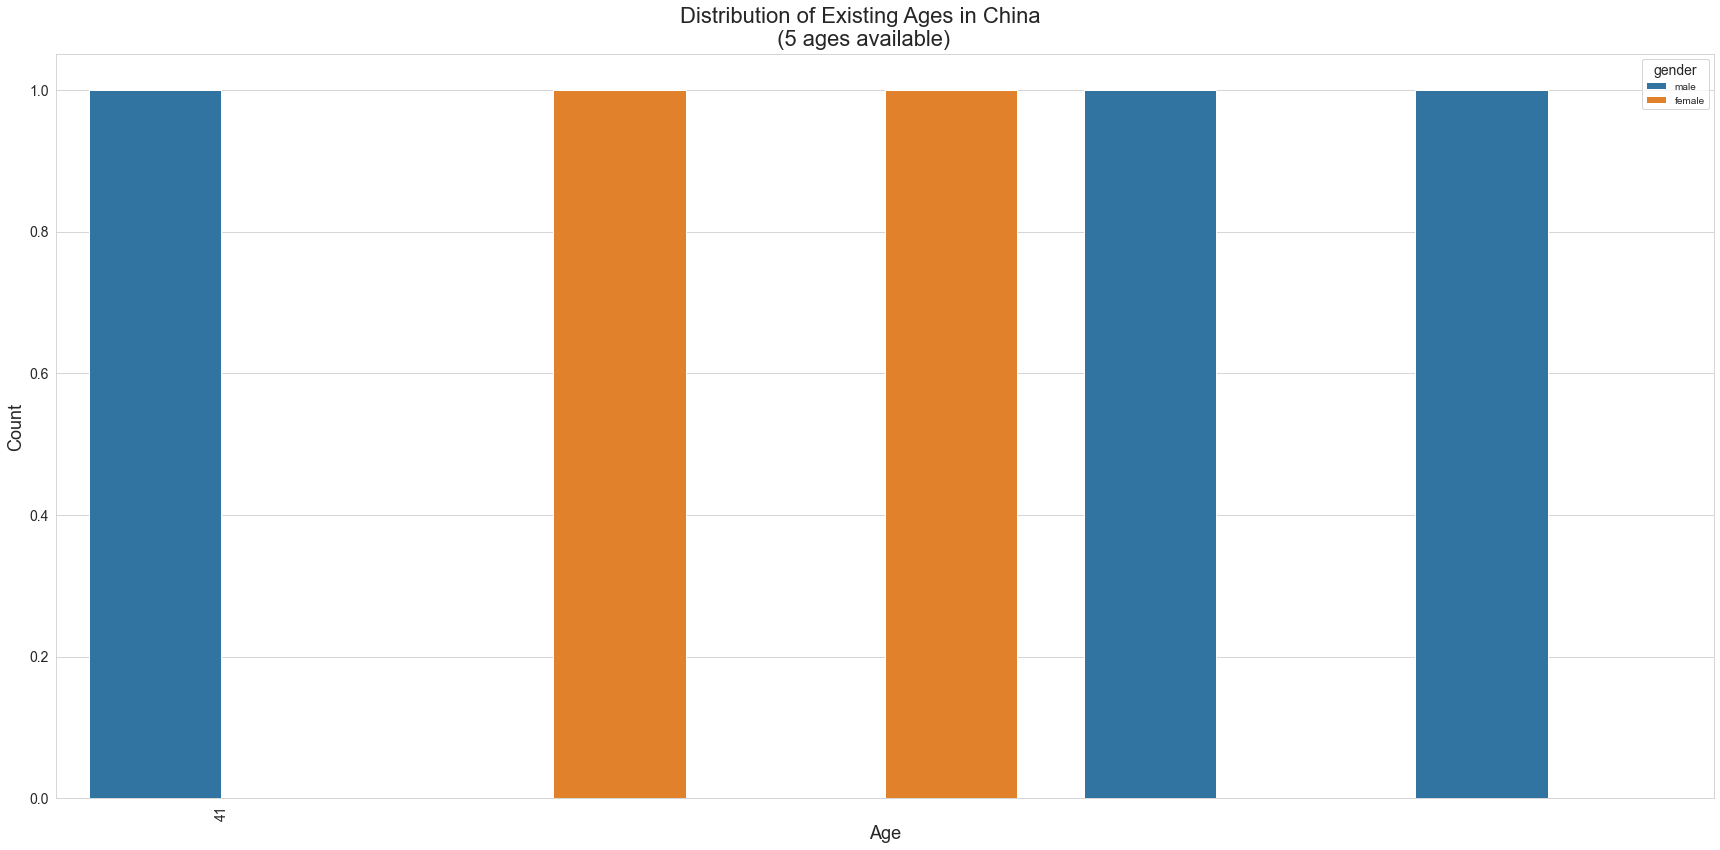

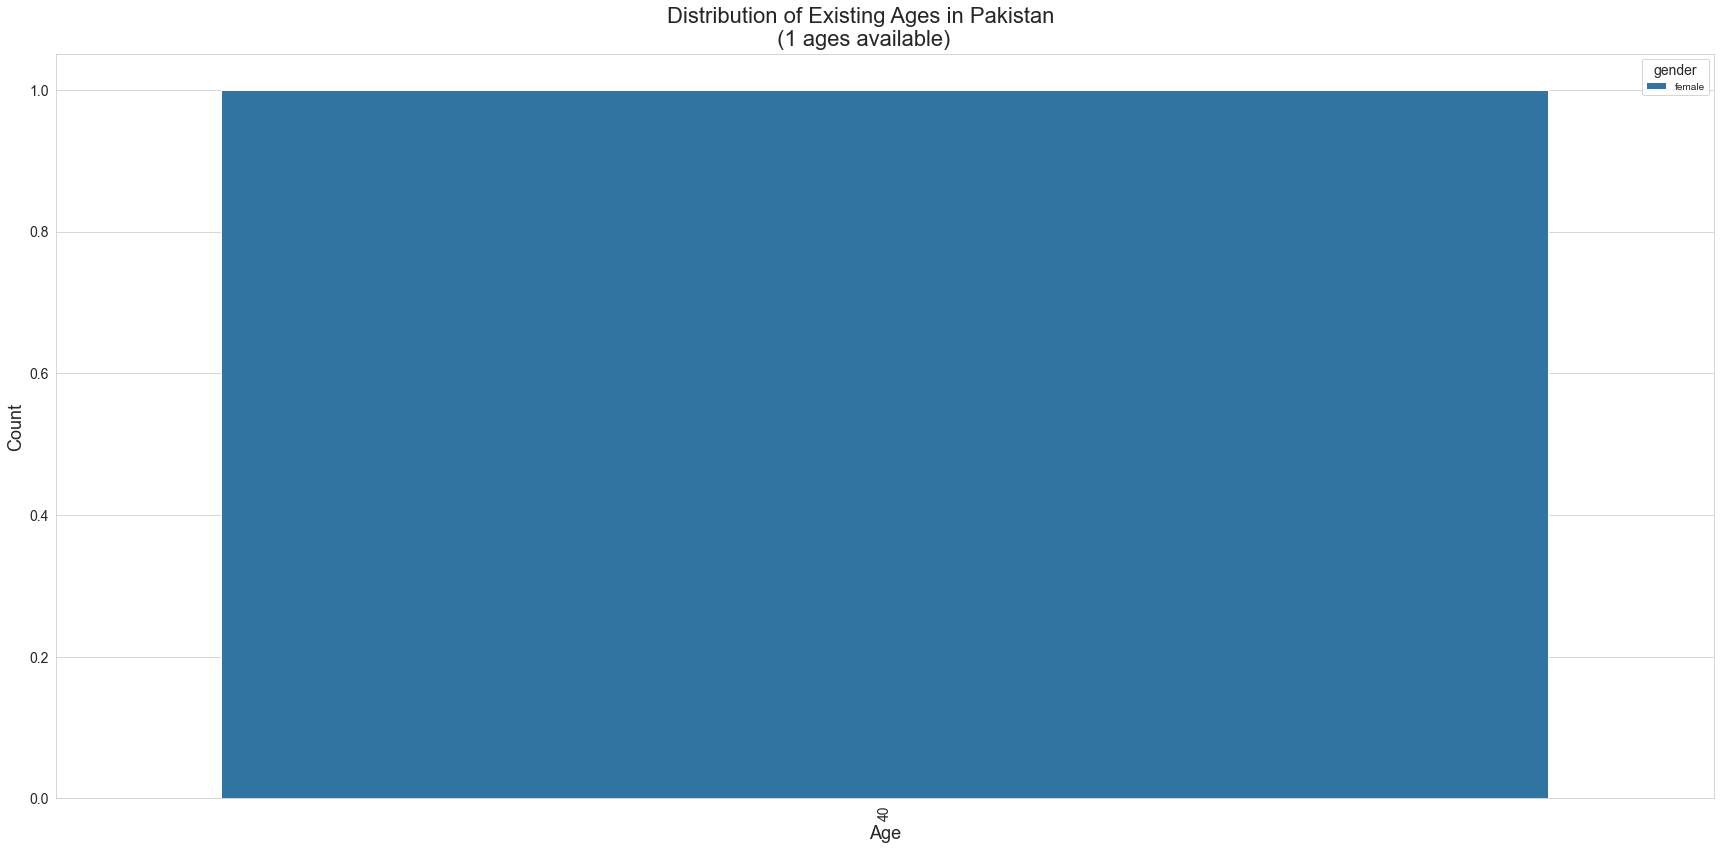

In [51]:
# Ensure that age distribution won't change for USA and check if other countries show interesting distributions
for country, age_count in plotdata['country'].value_counts().iteritems():
    fig, ax = plt.subplots(figsize=(24, 12))
    sns.countplot(data=plotdata[plotdata['country'] == country],
                  x='age',
                  hue='gender')
    fig.suptitle(f'Distribution of Existing Ages in {country}\n ({age_count} ages available)', fontsize=22)
    plt.xlabel('Age', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Show only every 5th x-tick
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.tight_layout()
    plt.savefig(f'../plots/age_distribution/age_distribution_{country}.png', dpi=300)
    plt.close()

# -> plot for USA is similiar to age distribution in USA, especially regarding rise around 20
# -> see e.g. https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/
# -> a bit more female samples are also quite realistic

# -> russian ages are mostly between 63 and 83

## Investigation of USA States

In [8]:
df_usa = df[df['country'] == 'USA']

In [3]:
# Filter for non-NaN regions
original_len_usa = len(df_usa)
df_usa = df_usa[df_usa['region'].notna()]
print(f'{original_len_usa - len(df_usa)} USA samples removed, now there are {len(df_usa)} samples.')

146392 USA samples removed, now there are 1110923 samples.


In [4]:
df_usa['region'].value_counts()

California         133086
Florida             81698
Minnesota           73512
Massachusetts       62987
Texas               59338
                    ...  
SC, McBee               1
PA, Landenberg          1
NJ, Clemson             1
NC, Advance             1
Kansas, Johnson         1
Name: region, Length: 1504, dtype: int64

In [5]:
df_usa['region'].nunique()  # 1504 regions -> includes more than just USA states

1504

In [33]:
import json

with open('json_data/usa_states.json') as f:
    usa_states = json.load(f)

# Note: "District of Columbia (Washington, D.C.)" does not belong to any state and therefore is listed additionally to 50 existing states
# See https://www.history.com/news/washington-dc-statehood-reconstruction
len(usa_states)

51

In [ ]:
import numpy as np

# Manually fix typos or too specific descriptions in "regions"
df_usa['region'].replace(['Californi', 'District of Columbia', 'Masschusetts, Essex county', 'Ilinois, Chicago', 'NewYork', 'Middlesex county'],
                         ['California', 'District Of Columbia', 'Massachusetts', 'Illinois', 'New York', 'New Jersey'], inplace=True)

def get_usa_states(region):
    # Get region by abbreviation
    if region.upper() in usa_states:
        return usa_states[region.upper()]
    # Get region by long version
    elif region.title() in list(usa_states.values()):
        return region.title()
    # Get region in front of comma
    elif region.split(',')[0].upper() in usa_states:
        return usa_states[region.split(',')[0].upper()]
    elif region.split(',')[0].title() in list(usa_states.values()):
        return region.split(',')[0].title()
    elif len(region.split(',')) >= 2:
        # Get region after first comma
        if region.split(',')[1].upper() in usa_states:
            return usa_states[region.split(',')[1].upper()]
        elif region.split(',')[1].title() in list(usa_states.values()):
            return region.split(',')[1].title()
        # Get region after first comma and whitespace
        elif region.split(',')[1][1:].upper() in usa_states:
            return usa_states[region.split(',')[1][1:].upper()]
        elif region.split(',')[1][1:].title() in list(usa_states.values()):
            return region.split(',')[1][1:].title()
    # Get region in front of slash and whitespace (catch special case "Louisiana / New Orleans")
    elif region.split('/')[0][:-1].title() in list(usa_states.values()):
        return region.split('/')[0][:-1].title()
    # Get region after whitespace (catch special case "SLIDELL LA")
    elif len(region.split(' ')) >= 2 and region.split(' ')[1].upper() in usa_states:
        return usa_states[region.split(' ')[1].upper()]
    else:
        return np.nan

# Add column with USA states in long version
df_usa['usa_state'] = df_usa.apply(lambda row: get_usa_states(str(row['region'])), axis=1)

In [35]:
# Check how many regions still contain more/less than state
unset_states = df_usa[df_usa['usa_state'].isna()]
unset_states['region'].value_counts() # -> 13 unique regions not assignable to state (islands, unknown, not existing abbreviations etc - as expected)

Puerto Rico                   1294
PR                             419
GU                             334
MP                             142
VI                              40
Unknown                         32
Guam                            15
NG                              14
Virgin Islands                   3
Virgin Islands of the U.S.       3
UNKNOWN                          3
CB                               1
NA, Santa Isabel                 1
Name: region, dtype: int64

In [40]:
display(df_usa['usa_state'].value_counts())

California              162136
Florida                 101068
Minnesota                74022
Texas                    65383
Massachusetts            63346
Washington               35892
North Carolina           35492
Georgia                  35039
Pennsylvania             33939
Colorado                 33524
Arizona                  29334
New Jersey               28532
Michigan                 27324
New York                 26364
Illinois                 25399
Tennessee                22262
Virginia                 21983
Ohio                     19841
Maryland                 18583
West Virginia            16749
Wisconsin                16491
Indiana                  15930
Utah                     15399
New Mexico               13578
South Carolina           13464
Nevada                   12288
Missouri                 11941
Alabama                  11229
Oregon                    9964
Arkansas                  9091
Kentucky                  8866
Vermont                   8746
Rhode Is

In [39]:
df_usa.to_csv('../data/metadata_EBI_usa_states.csv', index=False)

### Sample Count per State

Map needed from now on to know which states are near to each other.

In [ ]:
import pandas as pd

df_usa = pd.read_csv('../data/metadata_EBI_usa_states.csv')

In [ ]:
# install GDAL wheel file (https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal) and Fiona wheel file (https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona) before installing geopandas
import geopandas as gpd

In [8]:
# Shapefile taken from https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj
usa_geo = gpd.read_file('../data/geo_usa_states.shp')
usa_geo.head()

,drawseq,state_abbr,state_fips,state_name,sub_region,geometry
0,NaN,HI,15,Hawaii,Pacific,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,NaN,WA,53,Washington,Pacific,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,NaN,MT,30,Montana,Mountain,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,NaN,ME,23,Maine,New England,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,NaN,ND,38,North Dakota,West North Central,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


<AxesSubplot:>

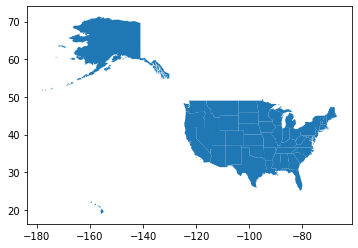

In [10]:
usa_geo.plot()

<AxesSubplot:>

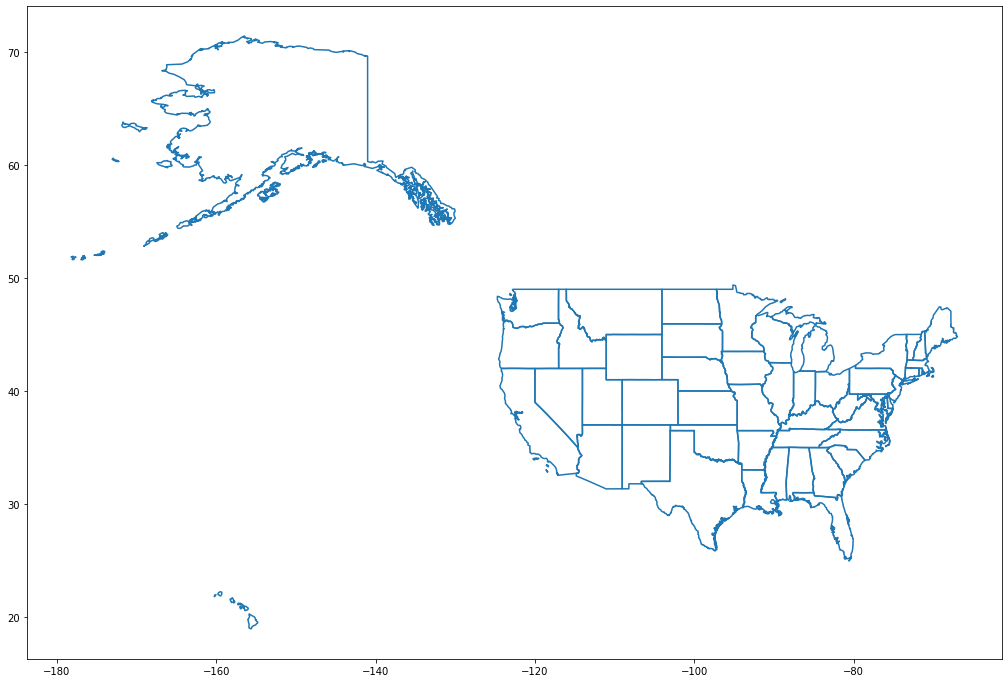

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(28, 12))

# Only plot boundaries
usa_geo.boundary.plot(ax=ax)

# Only plot boundaries and remove Hawaii (index 0, bottom left) and Alaska (index 51, upper left)
# usa_geo[1:50].boundary.plot(ax=ax)
# usa_geo[~usa_geo['state_name'].isin(['Alaska', 'Hawaii'])].boundary.plot(ax=ax)

In [ ]:
# Add number of samples per state as new column
state_counts = df_usa['usa_state'].value_counts().sort_index().to_dict()
usa_geo['state_count'] = usa_geo['state_name'].map(state_counts)

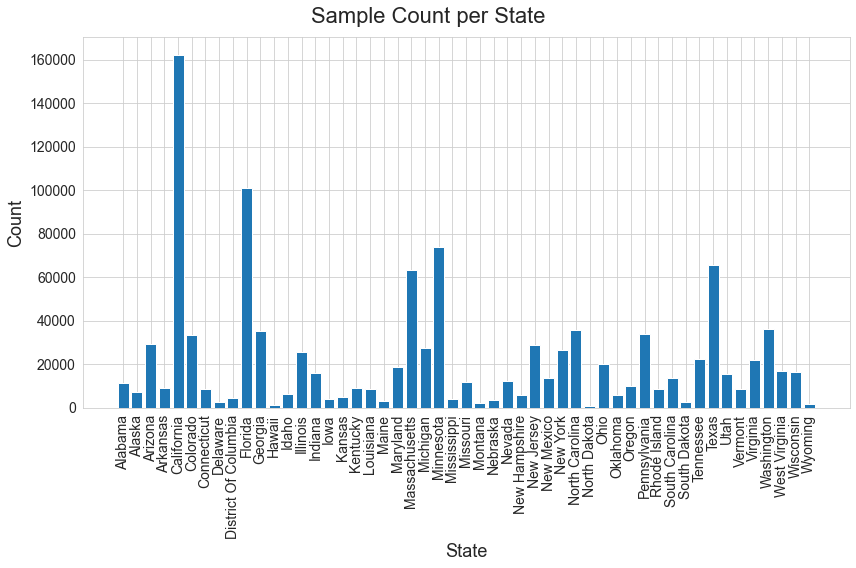

In [116]:
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(list(state_counts.keys()), list(state_counts.values()))

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/state_counts_barchart.png', dpi=300)
plt.close()

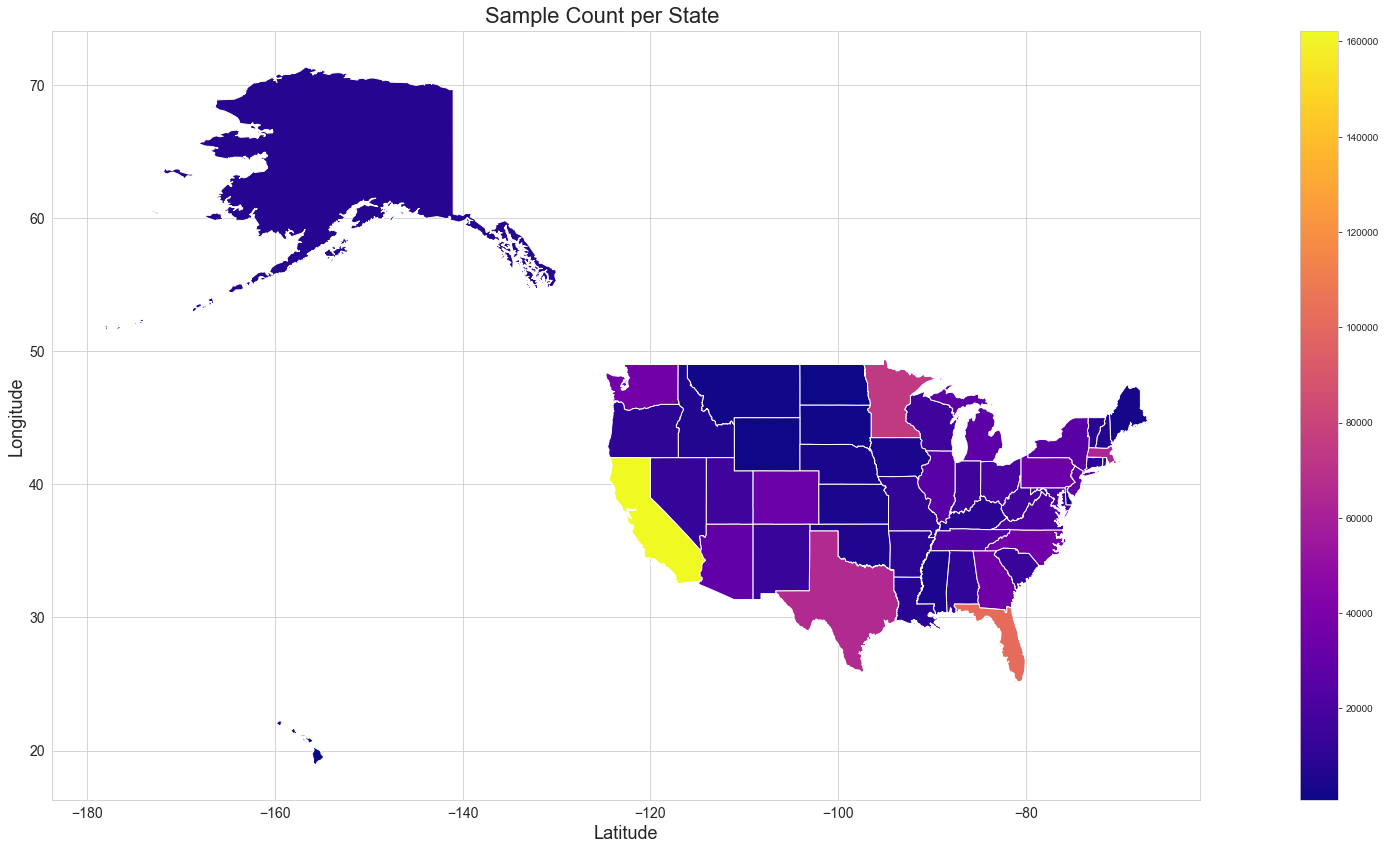

In [73]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
usa_geo.plot(column='state_count', ax=ax, legend=True, cmap='plasma')

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/state_counts_map.png', dpi=300)
plt.close()

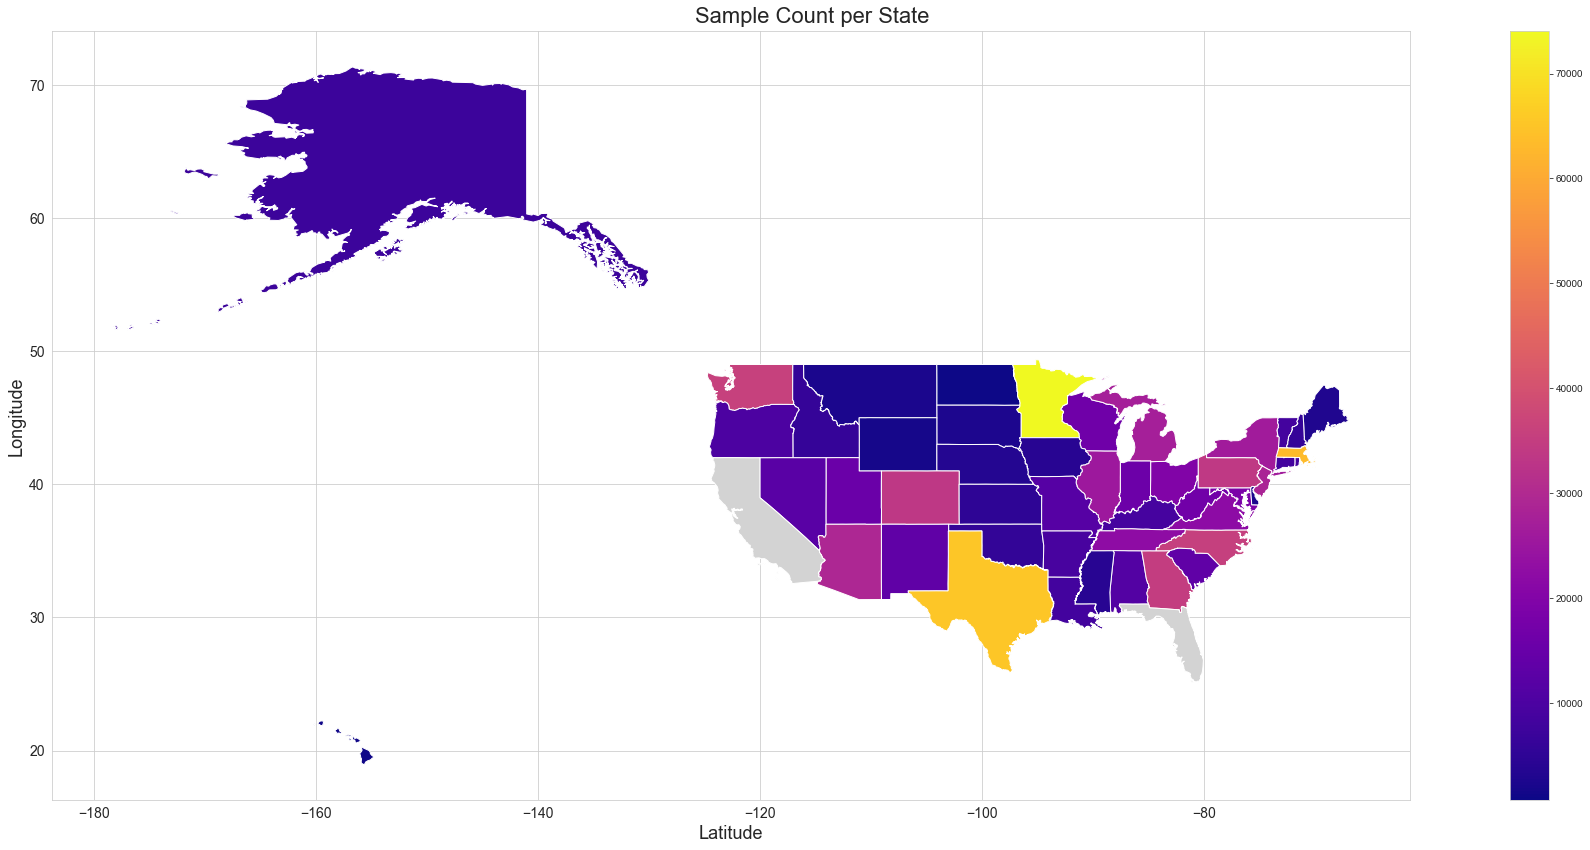

In [72]:
# Remove most represented states
plotdata = usa_geo[~usa_geo['state_name'].isin(['California', 'Florida'])]

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
plotdata.plot(column='state_count', ax=ax, legend=True, cmap='plasma')

# Add removed states as grey fields
usa_geo[usa_geo['state_name'].isin(['California', 'Florida'])].plot(color='lightgrey', ax=ax)

fig.suptitle('Sample Count per State', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/state_counts_map_reduced.png', dpi=300)
plt.close()

### Sample Count per State - Scaled by Number of Inhabitants

In [59]:
import json

with open('json_data/usa_states_inhabitants.json') as f:
    state_inhabitants = json.load(f)

usa_geo['n_inhabitants'] = usa_geo['state_name'].map(state_inhabitants)

In [61]:
usa_geo['count_inhabitant_ratio'] = usa_geo['state_count'] / usa_geo['n_inhabitants']

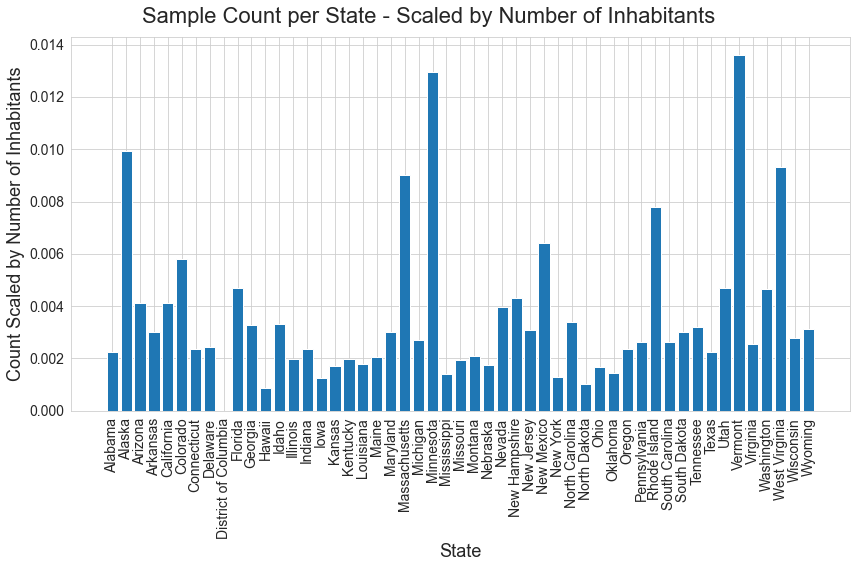

In [117]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
usa_geo = usa_geo.sort_values(by=['state_name'])
plt.bar(usa_geo['state_name'].tolist(), usa_geo['count_inhabitant_ratio'].tolist())

fig.suptitle('Sample Count per State - Scaled by Number of Inhabitants', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count Scaled by Number of Inhabitants', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/state_counts_by_inhabitants_barchart.png', dpi=300)
plt.close()

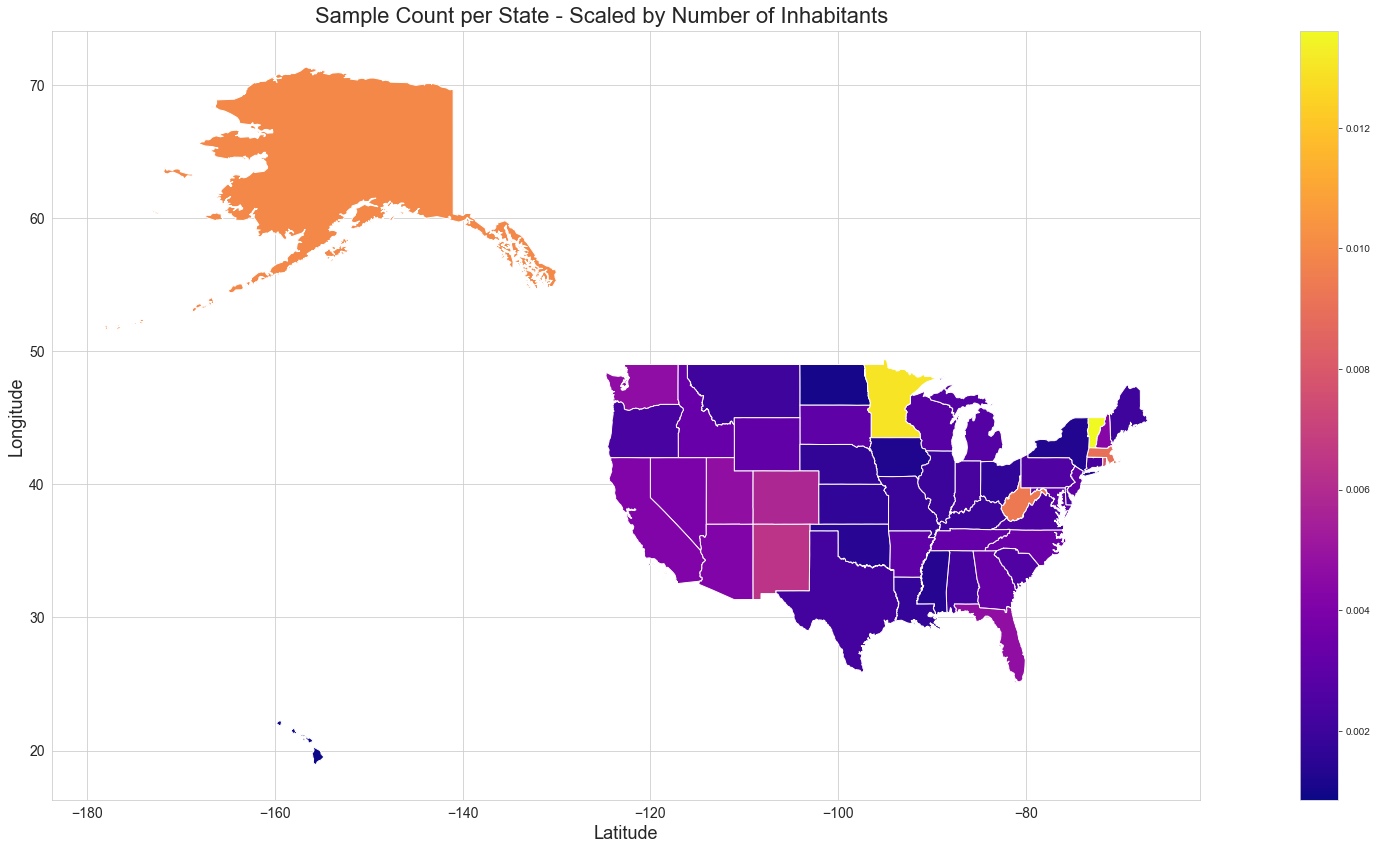

In [75]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(28, 12))
usa_geo.plot(column='count_inhabitant_ratio', ax=ax, legend=True, cmap='plasma')

fig.suptitle('Sample Count per State - Scaled by Number of Inhabitants', fontsize=22)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/state_counts_by_inhabitants_map.png', dpi=300)
plt.close()

### Sample Count per State - Scaled by Number of Infections

In [ ]:
# TODO: display amount of samples per state in relation to #infections